In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
X_full = pd.read_csv("/kaggle/input/titanic/train.csv")
X_test = pd.read_csv("/kaggle/input/titanic/test.csv")

In [3]:
#X.shape = (891, 11)
X_full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Variable	Definition	Key

survival	Survival	0 = No, 1 = Yes

pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd

sex	Sex	

Age	Age in years	

sibsp	# of siblings / spouses aboard the Titanic	

parch	# of parents / children aboard the Titanic	

ticket	Ticket number	

fare	Passenger fare	

cabin	Cabin number	

embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [4]:
X = X_full.copy()

In [5]:
#There are 11 features in total - including passenger Id and target.
#seperate target
y = X.Survived
y.shape

(891,)

In [6]:
X.drop('Survived', axis=1, inplace = True)

In [7]:
X.shape

(891, 11)

In [8]:
from sklearn.model_selection import train_test_split

X_train_full, X_valid_full, y_train, y_valid = train_test_split ( X,y,train_size = 0.8, test_size=0.2, random_state =0)

In [9]:
X_train_full.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            141
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          549
Embarked         2
dtype: int64

In [10]:
#select numerical columns

numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64','float64']]
print(numerical_cols)

['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [11]:
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 5 and X_train_full[cname].dtype =='object']
print(categorical_cols)

['Sex', 'Embarked']


In [12]:
# cabin and Ticket features are dropped

my_col = numerical_cols + categorical_cols
X_train = X_train_full[my_col].copy()
X_valid = X_valid_full[my_col].copy()

In [13]:
# numerical Imputer 
from sklearn.impute import SimpleImputer

numerical_imputer = SimpleImputer(strategy = 'mean')
X_train_num = numerical_imputer.fit_transform(X_train[numerical_cols])
X_valid_num = numerical_imputer.transform(X_valid[numerical_cols])

# Convert Numpy array back to DataFrame
X_train_num = pd.DataFrame(X_train_num, columns=numerical_cols, index=X_train_full.index)
X_valid_num = pd.DataFrame(X_valid_num, columns=numerical_cols, index=X_valid_full.index)

In [14]:
# categorical Imputer

categorical_imputer = SimpleImputer(strategy = 'most_frequent')

X_train_cat = categorical_imputer.fit_transform(X_train[categorical_cols])
X_valid_cat = categorical_imputer.transform(X_valid[categorical_cols])

# Convert Numpy array back to DataFrame
X_train_cat = pd.DataFrame(X_train_cat, columns=categorical_cols, index=X_train_full.index)
X_valid_cat = pd.DataFrame(X_valid_cat, columns=categorical_cols, index=X_valid_full.index)

In [15]:
X_train_imputed = pd.concat([X_train_num, X_train_cat] , axis=1)
X_valid_imputed = pd.concat([X_valid_num, X_valid_cat] , axis=1)

In [16]:
#one hot encoding using pandas

X_train_imputed = pd.get_dummies ( X_train_imputed)
X_valid_imputed = pd.get_dummies ( X_valid_imputed)

#X_train_imputed.shape = (712, 12)
#X_valid_imputed.shape = (179, 11)

#After one hot encoding , shape of train, valid, test may not be equal , therefore aligning has to be done

X_train_imputed, X_valid_imputed = X_train_imputed.align(X_valid_imputed , join='left' ,axis =1 )

#X_train_imputed.shape = (712, 12)
#X_valid_imputed.shape = (179, 12)

In [17]:
# Label encoding for categoricals
for colname in X_train_imputed.select_dtypes("object"):
    X[colname], _ = X_train_imputed[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X_train_imputed.dtypes == int

Visualize mutual info to understand the data better

In [18]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X_train_imputed, y_train, discrete_features)
mi_scores  # show a few features with their MI scores

Sex_female     0.147432
Sex_male       0.139875
Fare           0.098412
Pclass         0.045932
Embarked_Q     0.032521
Age            0.023939
Parch          0.015414
SibSp          0.000705
PassengerId    0.000000
Embarked_C     0.000000
Embarked_S     0.000000
Name: MI Scores, dtype: float64

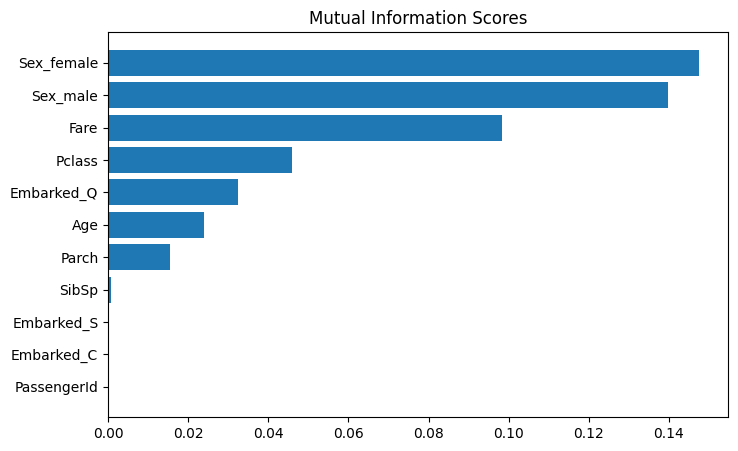

In [19]:
import matplotlib.pyplot as plt

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

Looks like Sex plays a major role in determining whether the passenger has survived or not

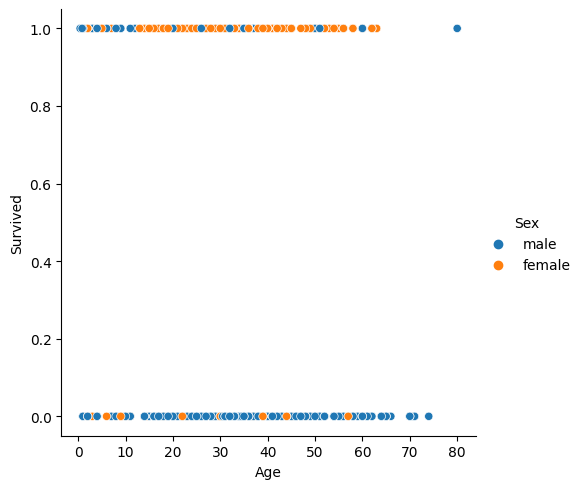

In [20]:
import seaborn as sns

sns.relplot(x="Age", y="Survived",hue='Sex', data=X_full);

From the above diagram , it can be visualized that more female passengers have survived than male

In [21]:
X_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [22]:
# Apply imputation to X_test
X_test_num = numerical_imputer.transform(X_test[numerical_cols])
X_test_num = pd.DataFrame(X_test_num, columns=numerical_cols, index=X_test.index)

X_test_cat = categorical_imputer.transform(X_test[categorical_cols])
X_test_cat = pd.DataFrame(X_test_cat, columns=categorical_cols, index=X_test.index)

X_test_imputed = pd.concat([X_test_num, X_test_cat], axis=1)

# One-hot encoding
X_test_imputed = pd.get_dummies(X_test_imputed)

# Align test set with train set
X_train_imputed, X_test_imputed = X_train_imputed.align(X_test_imputed, join='left', axis=1)


In [23]:
X_test_imputed.isna().sum()

PassengerId    0
Pclass         0
Age            0
SibSp          0
Parch          0
Fare           0
Sex_female     0
Sex_male       0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
dtype: int64

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_valid_scaled = scaler.fit_transform(X_valid_imputed)
X_test_scaled = scaler.fit_transform(X_test_imputed)

In [25]:
from xgboost import XGBClassifier

my_model = XGBClassifier(n_estimators = 1000, learning_rate = 0.15, n_jobs=4, max_depth=6)

my_model.fit(X_train_scaled,y_train, early_stopping_rounds=8, eval_set =[(X_valid_scaled,y_valid)], verbose = False)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=4,
              num_parallel_tree=None, random_state=None, ...)

In [26]:
prediction_valid = my_model.predict(X_valid_scaled)

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(prediction_valid, y_valid)
mse = mean_squared_error(prediction_valid, y_valid)

print(mae)
print(mse)

0.30726256983240224
0.30726256983240224


In [28]:
prediction = my_model.predict(X_test_scaled)

In [29]:
output = pd.DataFrame({'PassengerId': X_test.PassengerId, 'Survived': prediction})
output.to_csv('submission.csv', index=False)